In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings, os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from typing import Union, Literal
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, RegressorMixin, clone
import logging
from collections import defaultdict

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
logger = logging.getLogger('AminiSoil')
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s')

In [3]:
class SoilNutrientModel(BaseEstimator, RegressorMixin):
    def __init__(
            self, base_estimator=None, threshold=0.05, mi_scores=None, verbose=False, **kwargs):
        self.base_estimator = base_estimator
        self.threshold = threshold # feature selection threshold
        self.mi_scores = mi_scores  # DataFrame: columns are targets
        self.kwargs = kwargs
        self.verbose = verbose

    def fit(self, X, Y):
        self.estimators_ = []
        self.selected_features = []
        self.targets = [] # target variables
        self.all_cols = [] # saved selected variables for each target
        
        for target in Y.columns:
            self.targets.append(target)

            if self.verbose:
              logger.info('Fitting model for Nutrient: {}'.format(target))
            # Select MI features for this target
            mi = self.mi_scores[target]
            selected_features = mi[mi >= self.threshold].index
            # select those in X.columns
            selected_features = X.columns.intersection(selected_features).tolist()
            X_selected = X[selected_features]
            self.selected_features.append(selected_features)
            y_target = Y[target]

            self.all_cols.append(X_selected.columns) # append selected model
            X_selected = X_selected.values

            # Fit regressor
            model = clone(self.base_estimator).set_params(**self.kwargs)
            model.fit(X_selected, y_target)
            self.estimators_.append(model) # for feature importance
        return self

    def predict(self, X):
        preds = []
        for i in range(len(self.estimators_)):
            model = self.estimators_[i]
            selected_features = self.selected_features[i]
            X_selected = X[selected_features].values
            preds.append(model.predict(X_selected))
        return np.column_stack(preds)


In [4]:
def calculate_mutual_information(X, y, seed):
    cols = X.columns
    scores = mutual_info_regression(X, y, random_state=seed)
    scores = pd.Series(scores, index=cols, name='score')
    return scores

def select_top_features(mutual_scores, threshold=0.85, by_cumum=True):
    """
    Selects top features based on a MI score or cumulative sum of the normalised MI score threshold
    """
    if by_cumum:
        mutual_scores_sorted = mutual_scores.sort_values(ascending=False).transform(lambda x: x/x.sum()).cumsum()
        selected_cols = mutual_scores_sorted[mutual_scores_sorted <= threshold].index.tolist()
    else:
        selected_cols = mutual_scores[mutual_scores >= threshold].index.tolist()
    return selected_cols

In [5]:
def feature_selection_cv(X, y, cv, seed):
    """
    Calculates MI scores based on a cross-validation
    """
    skfold = KFold(n_splits=cv, random_state=seed, shuffle=True)
    mi_scores = []
    i = 0
    for train_idx,  _ in (skfold.split(X, y)):
        xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
        # calculate MI
        score = calculate_mutual_information(xtrain, ytrain, seed)
        mi_scores.append(score)
        i += 1
    mi_scores = pd.concat(mi_scores, axis=1).mean(1).sort_values(ascending=False)
    return mi_scores

In [6]:
train = pd.read_parquet('data/train_preprocessed.parquet')
test = pd.read_parquet('data/test_preprocessed.parquet')
train_gap = pd.read_csv('data/Gap_Train.csv')
test_gap = pd.read_csv('data/Gap_Test.csv')

In [7]:
train.shape, test.shape

((7744, 222), (2418, 211))

In [8]:
train_gap.shape, test_gap.shape

((85184, 5), (26598, 3))

In [9]:
train_gap.head()

,Nutrient,Required,Available,Gap,PID
0,N,100.0,3796.0000,-3696.0000,ID_I5RGjv
1,P,40.0,0.9928,39.0072,ID_I5RGjv
2,K,52.0,429.2400,-377.2400,ID_I5RGjv
3,Ca,12.0,19943.6000,-19931.6000,ID_I5RGjv
4,Mg,8.0,6745.2000,-6737.2000,ID_I5RGjv


In [10]:
train.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B,ET_mean,ET_std,PET_mean,PET_std,wsi_mean,wsi_std,ET_coef_var,PET_coef_var,wsi_coef_var,wsi_amplitude,wsi_phase,wsi_auc,wsi_slope,LST_Day_1km_mean,LST_Day_1km_std,LST_Night_1km_mean,LST_Night_1km_std,daily_LST_mean,daily_LST_std,LST_diff_mean,LST_diff_std,LST_Day_1km_coef_var,LST_Night_1km_coef_var,daily_LST_coef_var,LST_diff_coef_var,daily_LST_amplitude,daily_LST_phase,daily_LST_auc,LST_diff_amplitude,LST_diff_phase,LST_diff_auc,daily_LST_slope,LST_diff_slope,blue_mean,blue_std,green_mean,green_std,red_mean,red_std,nir_mean,nir_std,swir1_mean,swir1_std,swir2_mean,swir2_std,swir3_mean,swir3_std,ST_B10_mean,ST_B10_std,evi_mean,evi_std,ndvi_mean,ndvi_std,ndmi_mean,ndmi_std,bsi_mean,bsi_std,msi_mean,msi_std,gndvi_mean,gndvi_std,nbr_mean,nbr_std,savi_mean,savi_std,brightness_temp_mean,brightness_temp_std,nbr2_mean,nbr2_std,red_blue_ratio_mean,red_blue_ratio_std,swir1_3_ratio_mean,swir1_3_ratio_std,blue_coef_var,green_coef_var,red_coef_var,nir_coef_var,swir1_coef_var,swir2_coef_var,swir3_coef_var,ST_B10_coef_var,evi_coef_var,ndvi_coef_var,ndmi_coef_var,bsi_coef_var,msi_coef_var,gndvi_coef_var,nbr_coef_var,savi_coef_var,brightness_temp_coef_var,nbr2_coef_var,red_blue_ratio_coef_var,swir1_3_ratio_coef_var,evi_amplitude,evi_phase,evi_auc,ndvi_amplitude,ndvi_phase,ndvi_auc,gndvi_amplitude,gndvi_phase,gndvi_auc,savi_amplitude,savi_phase,savi_auc,land_surf_index_amplitude,land_surf_index_phase,land_surf_index_auc,veg_index_amplitude,veg_index_phase,veg_index_auc,moisture_index_amplitude,moisture_index_phase,moisture_index_auc,veg_sm_index_amplitude,veg_sm_index_phase,veg_sm_index_auc,baresoil_burn_index_amplitude,baresoil_burn_index_phase,baresoil_burn_index_auc,sm_bb_index_amplitude,sm_bb_index_phase,sm_bb_index_auc,brightness_temp_amplitude,brightness_temp_phase,brightness_temp_auc,evi_slope,ndvi_slope,gndvi_slope,savi_slope,land_surf_index_slope,veg_index_slope,moisture_index_slope,veg_sm_index_slope,baresoil_burn_index_slope,sm_bb_index_slope,VH_mean,VH_std,VV_mean,VV_std,vv_vh_mean,vv_vh_std,vv_vh_diff_mean,vv_vh_diff_std,ndpi_mean,ndpi_std,VH_coef_var,VV_coef_var,vv_vh_coef_var,vv_vh_diff_coef_var,ndpi_coef_var,vv_vh_amplitude,vv_vh_phase,vv_vh_auc,vv_vh_diff_amplitude,vv_vh_diff_phase,vv_vh_diff_auc,vv_vh_slope,vv_vh_diff_slope,dryness_index,diurnal_temp_range,rainfall_precip_ratio,org_density,sand_org_carbon_ratio,cec_efficiency,cec_comb,ph_diff,ph_comb,acidity_ratio,tim_slope_ratio,tim_slope,slope_elev,slope_elev_ratio,alb_para,sand_organic_carbon,rainfall_elev,ph_cec,ph_soc20
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,1300.0,0.34,147.0,6830.0,2310.0,5.66,75.2,85.0,0.82,2.98,0.24,4.733796,5.804111,64.060880,16.381475,0.101589,0.144538,1.226101,0.255717,1.422773,0.157541,1.905200,1.201723,0.014775,313.573477,5.733600,294.139667,2.070361,303.856572,3.785164,19.433811,4.124471,0.018285,0.007039,0.012457,0.212232,4.144750,-1.719659,3337.085772,4.822212,-1.560567,206.572481,-0.460621,-0.540501,0.112693,0.157650,0.135376,0.152965,0.190691,0.136421,0.235559,0.126288,0.361928,0.105941,0.379170,0.072835,0.241724,0.068031,0.955034,0.126015,0.069206,0.034354,0.126511,0.063201,-0.233693,0.097097,-0.104363,0.172590,1.770724,0.373902,0.348207,0.130595,-0.260830,0.134558,0.078166,0.039603,196.942381,4.632956,0.029473,0.108100,2.281200,0.572623,0.679026,0.124064,1.398934,1.129929,0.715404,0.536120,0.292711,0.192090,0.281440,0.131948,0.496396,0.499566,-0.415489,-1.653748,0.211158,0.375050,-0.515885,0.506657,0.023524,3.667831,0.251018,0.182708,0.041697,-1.213240,0.743867,0.072558,-1.083624,1.352631,0.102986,-1.073355,3.789365,0.04

In [11]:
target_variables = train.loc[:, 'N':'B'].columns.tolist()
target_variables_str = '^'+ '$|^'.join(target_variables) + '$'

In [12]:
transform_type = None
scaler = MinMaxScaler()

In [13]:
def transform_predictions(preds, transform_type):
    """
    Transforms target predictions to original values
    """
    if transform_type == 'sqrt':
        preds = np.square(preds)
    elif transform_type == 'log1p':
        preds = np.expm1(preds)
    elif callable(transform_type):
        preds = transform_type(preds)
    return preds

In [14]:
def eval_metrics(y_actual, y_preds, transform=None):
    y_actual = transform_predictions(y_actual, transform)
    y_preds = transform_predictions(y_preds, transform)
    rmse = root_mean_squared_error(y_actual, y_preds)
    r2 = r2_score(y_actual, y_preds)
    mse = np.square(rmse)
    mae = mean_absolute_error(y_actual, y_preds)
    res = pd.DataFrame({'RMSE':[rmse], 'MAE':[mae], 'MSE':[mse], 'R2':[r2]}, index=['scores'])
    return res

In [15]:
def calculate_regression_eval_metrics(model, X, y, target_scaled=False, transform=None, return_individual_result=False):
    results = []

    y_preds = scaler.inverse_transform(model.predict(X)) if target_scaled else model.predict(X)
    y_actual = scaler.inverse_transform(y) if target_scaled else y.values

    if not return_individual_result:
        return eval_metrics(y_actual, y_preds, transform)
    else:
        for i, col in enumerate(target_variables):
            res = eval_metrics(y_actual[:, i], y_preds[:, i], transform)
            res.index = [col]
            results.append(res)
        return pd.concat(results, axis=0).round(3)

In [16]:
def get_feature_importances(model):
    feature_importance_scores = []
    for i, target in enumerate(target_variables):
        model_target = model.estimators_[i]
        input_features = model.all_cols[i]
        imp_scores = pd.Series(model_target.feature_importances_, index=input_features)
        feature_importance_scores.append(imp_scores.transform(lambda x: x/x.sum()))
    return feature_importance_scores

def plot_feature_importance(importance_scores:dict, nrow=3, ncol=4, topn=20, figsize=(15,15)):
    fig = plt.figure(figsize=figsize)
    i = 0
    for col in tqdm(importance_scores.keys()):
        imp_score = importance_scores[col]
        plt.subplot(nrow, ncol, i+1)
        imp_score.nlargest(topn)[::-1].plot.barh(fontsize=8)
        plt.title(col, fontsize=9)
        i += 1
    plt.tight_layout()
    plt.suptitle('Feature Importances', y=1.01, fontweight='bold');

In [17]:
def eval_metrics_gap(model, X, y, gap_df, target_scaled=False, transform_type=None, return_individual_results=True):
    idx_vals = X.index.tolist()
    X_gap = gap_df.copy()
    PIDs = train.iloc[idx_vals][['PID', 'BulkDensity']]
    # y_copy = y.copy().reset_index(drop=True)
    predictions = model.predict(X)
    if target_scaled:
        predictions = scaler.inverse_transform(predictions)

    # transform predictions back to original values
    predictions = transform_predictions(predictions, transform_type)
    predictions = pd.DataFrame(predictions, columns=target_variables, index=idx_vals)

    preds_df = pd.concat([PIDs, predictions], axis=1)
    preds_df = pd.melt(preds_df, id_vars=['PID', 'BulkDensity'], var_name='Nutrient', value_name='Available_pred_in_ppm')
    preds_df = pd.merge(preds_df, X_gap, on=['Nutrient', 'PID'])

    soil_depth = 20  # cm

    # Calculate the Available_Nutrients_in_kg_ha
    preds_df['Available_pred_in_kg_ha'] = (preds_df['Available_pred_in_ppm'] * soil_depth * preds_df['BulkDensity'] * 0.1)
    preds_df["Gap_pred"] = preds_df["Required"] - preds_df["Available_pred_in_kg_ha"]

    rmse = root_mean_squared_error(preds_df['Gap'], preds_df['Gap_pred'])
    mae = mean_absolute_error(preds_df['Gap'], preds_df['Gap_pred'])
    if return_individual_results:
        print(f'RMSE: {rmse:.5f}\tMAE: {mae:.5f}\n')
        # print for all
        eval_results = pd.DataFrame(columns=['Nutrient', 'RMSE', 'MAE'])
        for col in target_variables:
            res = preds_df.query(f'Nutrient == "{col}"')[['Gap', 'Gap_pred']]
            rmse = root_mean_squared_error(res['Gap'], res['Gap_pred'])
            mae = mean_absolute_error(res['Gap'], res['Gap_pred'])
            eval_results = pd.concat([eval_results, pd.DataFrame([[col, rmse, mae]], columns=['Nutrient', 'RMSE', 'MAE'])])
        return eval_results.set_index('Nutrient').T
    else:
        return pd.DataFrame({'RMSE':[rmse], 'MAE': [mae]})

In [18]:
def create_predictions_table(model_predictions, gap_df):
    X_gap = gap_df.copy()
    PIDs = test[['PID', 'BulkDensity']].reset_index(drop=True)
    # y_copy = y.copy().reset_index(drop=True)
    predictions = pd.DataFrame(model_predictions, columns=target_variables)
    preds_df = pd.concat([PIDs, predictions], axis=1)

    preds_df = pd.melt(preds_df, id_vars=['PID', 'BulkDensity'], var_name='Nutrient', value_name='Available_pred_in_ppm')
    preds_df = pd.merge(preds_df, X_gap, on=['Nutrient', 'PID'], how='right')

    soil_depth = 20  # cm
    # Calculate the Available_Nutrients_in_kg_ha
    preds_df['Available_pred_in_kg_ha'] = (preds_df['Available_pred_in_ppm'] * soil_depth * preds_df['BulkDensity'] * 0.1)
    preds_df["Gap_pred"] = preds_df["Required"] - preds_df["Available_pred_in_kg_ha"]
    preds_df = preds_df.assign(ID = preds_df.PID + '_' + preds_df.Nutrient)
    return preds_df.sort_values('ID').reset_index(drop=True)

In [19]:
def save_file(df, filename):
    os.makedirs('preds/', exist_ok=True)
    preds_df = df[['ID', 'Gap_pred']].rename({'Gap_pred' : 'Gap'}, axis=1)
    filepath = os.path.join('preds', filename)
    preds_df.to_csv(f'{filepath}.csv', index=False)

In [20]:
def cross_val_predictions(reg, X, y, xtest, cv:Union[int,callable], target_scaled=False,
                          groups=None, random_state=None, return_feature_importance=False):
    y = pd.DataFrame(y, columns=target_variables) if target_scaled else y
    i = 0
    test_predictions = []
    val_ppm_scores = []
    val_gap_scores = []
    feature_importance_scores = defaultdict(list)
    multioutput = reg.__class__.__name__ == 'SoilNutrientModel'

    if isinstance(cv, int):
        cv = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    for train_idx, val_idx in cv.split(X,y, groups=groups):
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        reg.fit(x_train, y_train)
        # predictions on test set
        test_predictions.append(reg.predict(xtest)) # store raw predictions
        # evaluation
        ppm_scores = calculate_regression_eval_metrics(reg, x_val, y_val, target_scaled=target_scaled, transform=transform_type,
                                                       return_individual_result=False)[['RMSE', 'MAE']].values.ravel()

        gap_scores = eval_metrics_gap(reg, x_val, y_val, gap_df=train_gap, target_scaled=target_scaled, 
                                      transform_type=transform_type, return_individual_results=False).values.ravel()

        val_gap_scores.append(gap_scores)
        val_ppm_scores.append(ppm_scores)

        print(f'Fold {i+1}')
        print(f'PPM Scores: RMSE: {ppm_scores[0]:.5f}\tMAE: {ppm_scores[1]:.5f}')
        print(f'Gap Scores: RMSE: {gap_scores[0]:.5f}\tMAE: {gap_scores[1]:.5f}')
        print('+=+'*25)
        print()

        if hasattr(reg.estimators_[0], 'feature_importances_'):
            scores = get_feature_importances(reg)
            for col, score in zip(target_variables, scores):
                feature_importance_scores[col].append(score)
        i += 1
    val_ppm_mean = np.mean(val_ppm_scores, axis=0)
    val_ppm_sd = np.std(val_ppm_scores, axis=0)
    val_gap_mean = np.mean(val_gap_scores, axis=0)
    val_gap_sd = np.std(val_gap_scores, axis=0)
    gap_95_CI = np.quantile(np.array(val_gap_scores)[:, 0], q=[0.025, 0.975])

    print(f'PPM Scores: RMSE: {val_ppm_mean[0]:.4f} +- {val_ppm_sd[0]:.4f}\tMAE: {val_ppm_mean[1]:.4f} +- {val_ppm_sd[1]:.4f}')
    print(f'Gap Scores: RMSE: {val_gap_mean[0]:.4f} +- {val_gap_sd[0]:.4f}\tMAE: {val_gap_mean[1]:.4f} +- {val_gap_sd[1]:.4f}')
    print(f'Gap Scores (95% CI): RMSE: [{gap_95_CI[0]:.4f}, {gap_95_CI[1]:.4f}]')

    test_predictions = np.mean(test_predictions, axis=0) # average raw predictions first
    test_predictions = transform_predictions(test_predictions, transform_type=transform_type) # then apply transform
    test_predictions = scaler.inverse_transform(test_predictions) if target_scaled else test_predictions # finally inverse scale if needed

    if return_feature_importance:
        for i, key in enumerate(feature_importance_scores.keys()):
            feature_importance_scores[key] = pd.Series(np.mean(feature_importance_scores[key], axis=0), index=reg.all_cols[i])
        return test_predictions, feature_importance_scores
    else:
        return test_predictions

In [21]:
seed = 483

__Feature selection__

In [22]:
selected_features = train.columns.drop(['PID', 'site', 'lat', 'lon', 'mb1', 'mb2', 'mb3', 'mb7']+target_variables) # , 'lat', 'lon' , 'mb1', 'mb2', 'mb3', 'mb7'

In [23]:
mi_scores_target = {}
for i, col in tqdm(enumerate(target_variables), total=len(target_variables)):
    mutual_ci = feature_selection_cv(train[selected_features], train[col], cv=5, seed=seed)
    mi_scores_target[col] = mutual_ci

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [09:01<00:00, 49.27s/it]


In [24]:
mi_scores = pd.DataFrame(mi_scores_target)
mi_scores.to_csv('data/mi_scores_target.csv')

In [25]:
mi_scores.head()

,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
BulkDensity,0.152525,0.058968,0.055542,0.159269,0.120912,0.055489,0.045690,0.037316,0.032799,0.038829,0.058152
ET_coef_var,0.114776,0.052604,0.120818,0.081329,0.079734,0.041048,0.064615,0.022505,0.075541,0.091024,0.086450
ET_mean,0.145501,0.069469,0.074966,0.124090,0.101888,0.077136,0.042841,0.025111,0.092592,0.065255,0.081857
ET_std,0.054594,0.085079,0.026273,0.101997,0.055214,0.059523,0.051243,0.010628,0.004577,0.064170,0.072191
LST_Day_1km_coef_var,0.049217,0.064016,0.050498,0.064051,0.027441,0.032422,0.059975,0.040036,0.036266,0.037844,0.101459


In [26]:
rf = RandomForestRegressor(n_estimators=300, max_features=0.5, random_state=seed,
                           min_samples_leaf=2, min_samples_split=5, n_jobs=-1)

In [27]:
rf_model = SoilNutrientModel(rf, mi_scores=mi_scores, verbose=False)

In [29]:
# dropping mb1-6, range, min, max
rf_preds, rf_imp = cross_val_predictions(rf_model,
                                         train[selected_features],
                                         train[target_variables],
                                         test[selected_features],
                                         cv=5, random_state=seed, 
                                         return_feature_importance=True)

Fold 1
PPM Scores: RMSE: 235.16655	MAE: 157.18796
Gap Scores: RMSE: 1200.30406	MAE: 397.11132
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 2
PPM Scores: RMSE: 239.60868	MAE: 161.11054
Gap Scores: RMSE: 1211.57921	MAE: 405.59606
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 3
PPM Scores: RMSE: 236.60804	MAE: 157.26761
Gap Scores: RMSE: 1227.42806	MAE: 396.28187
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 4
PPM Scores: RMSE: 252.73108	MAE: 163.27946
Gap Scores: RMSE: 1299.95356	MAE: 411.08260
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

Fold 5
PPM Scores: RMSE: 247.22725	MAE: 158.30545
Gap Scores: RMSE: 1357.68909	MAE: 399.76025
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+

PPM Scores: RMSE: 242.2683 +- 6.6874	MAE: 159.4302 +- 2.3921
Gap Scores: RMSE: 1259.3908 +- 60.1776	MAE: 401.9664 +- 5.6041
Gap Scores (95% CI): 

100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


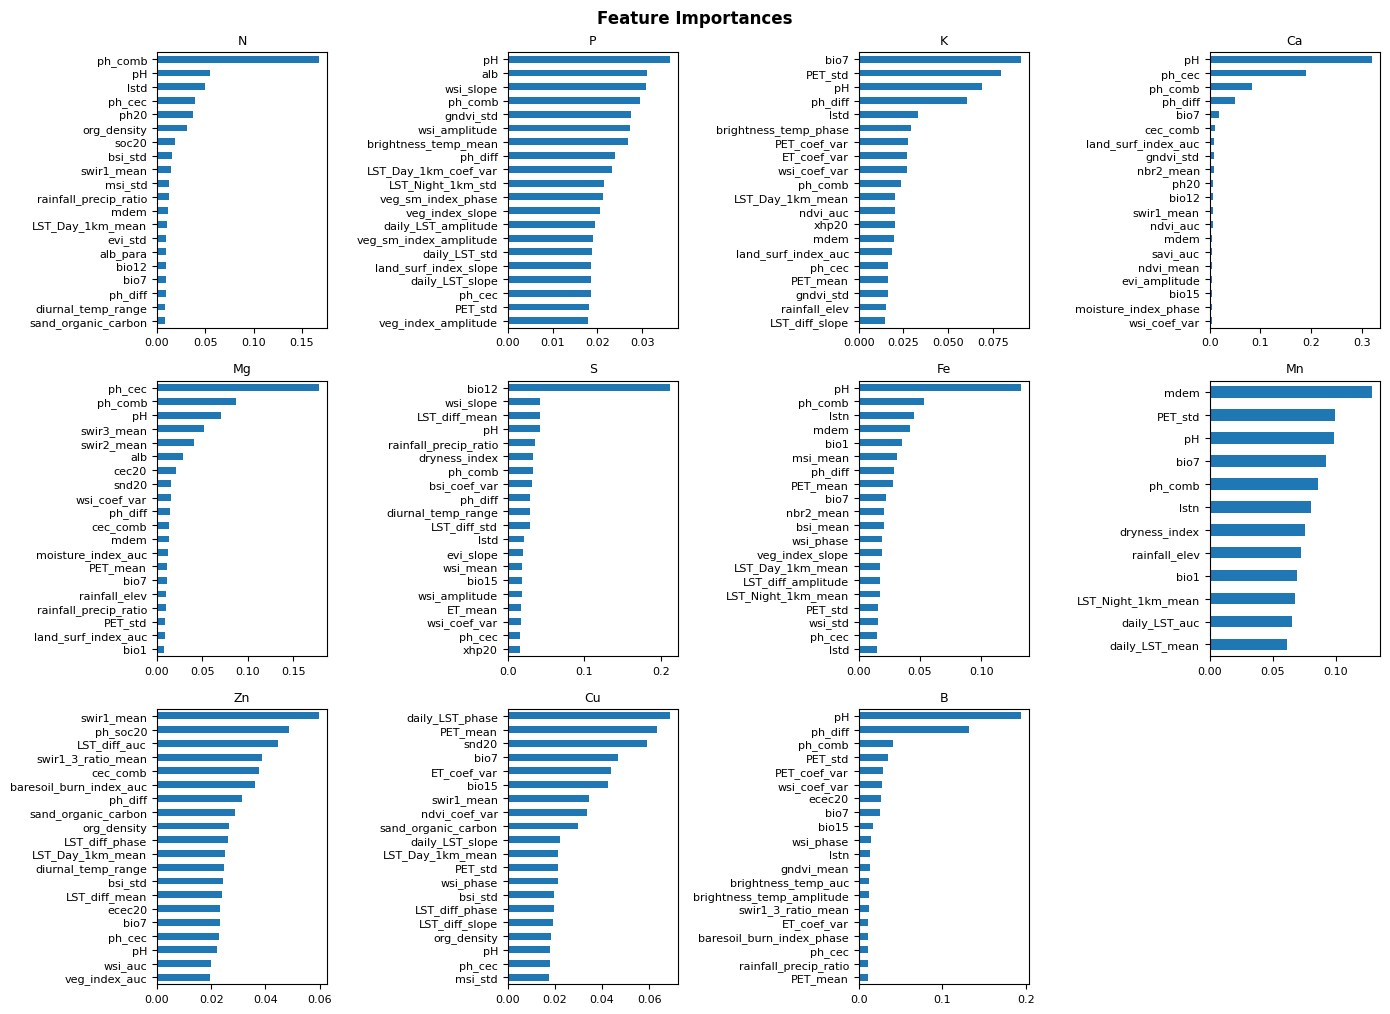

In [30]:
plot_feature_importance(rf_imp, figsize=(14, 10))

In [31]:
rf_preds_df = create_predictions_table(rf_preds, test_gap)
rf_preds_df.head()

,PID,BulkDensity,Nutrient,Available_pred_in_ppm,Required,Available_pred_in_kg_ha,Gap_pred,ID
0,ID_002W8m,1.15,B,0.350954,0.08,0.807194,-0.727194,ID_002W8m_B
1,ID_002W8m,1.15,Ca,2632.606968,12.00,6054.996026,-6042.996026,ID_002W8m_Ca
2,ID_002W8m,1.15,Cu,4.296163,0.20,9.881174,-9.681174,ID_002W8m_Cu
3,ID_002W8m,1.15,Fe,140.358458,0.80,322.824454,-322.024454,ID_002W8m_Fe
4,ID_002W8m,1.15,K,512.626639,52.00,1179.041271,-1127.041271,ID_002W8m_K


In [32]:
save_file(rf_preds_df, 'rf_preds_mi_005')